In [59]:
import numpy as np
np.set_printoptions(suppress=True)
import joblib
from keras.models import load_model
from keras.preprocessing import image as kimage
from keras.preprocessing.image import img_to_array
import cv2 as cv
import pickle

face_detector = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

#!pip install git+https://github.com/rcmalli/keras-vggface.git

from keras.models import Model
import keras_vggface
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

import sounddevice as sd
import scipy
from scipy.io import wavfile as wav
from pydub import AudioSegment
from pydub.silence import split_on_silence
import librosa


import keras
from keras.applications import mobilenet_v2
#from tqdm import tqdm
#keras.__version__

#from sklearn.neighbors import KDTree

from PIL import Image
from matplotlib import pyplot as plt

#from time import time
import os
import mtcnn


# SOUND

In [2]:
audio_model = load_model("audio_NN_model_monocanale.h5")

#### Feature extraction

In [32]:
def extract_feature(X):
    
    X, sample_rate = librosa.load(X)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    
    return mfccs,chroma,mel,contrast,tonnetz

def test_audio(filename):
    
    features = []
    mfccs, chroma, mel, contrast, tonnetz = extract_feature(filename)
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    features.append(ext_features)
    return np.array(features)


def predict(filename): 
    
    test = test_audio(filename)
    predicted = np.round(audio_model.predict_classes(test), 5)
    acc = round(np.max(audio_model.predict(test)),4)
    if predicted[0] == 0: 
        print ('Federica' +'. Accuracy: ' + str(acc))
    if predicted[0] == 1: 
        print ('Giulia'+'. Accuracy: ' + str(acc))
    if predicted[0] == 2: 
        print ('Sconosciuto'+'. Accuracy: ' + str(acc))
        
    return predicted

In [31]:
test_federica = predict("test_federica_chunk.wav")

Federica. Accuracy: 0.9999


In [33]:
test_giulia = predict("test_giulia_chunk.wav")

Giulia. Accuracy: 0.997


In [34]:
test_sconosciuto = predict("test_sconosciuto_chunk.wav")

Sconosciuto. Accuracy: 0.9979


#### Test with live audio

In [49]:
fs = 44100
second = 5

rec = sd.rec(int(second * fs), samplerate=fs, channels=1, blocking=True)
sd.wait()

# !! rename file before recording !!
wav.write('test_live.wav', fs, rec)

In [50]:
rec = AudioSegment.from_wav('test_live.wav')

chunks = split_on_silence (
    rec,
    min_silence_len = 200,
    silence_thresh = -50
)

#scegliere il chunk migliore
chunks[1]

In [51]:
chunks[1].export(
        "test.wav",
        bitrate = "300k",
        format = "wav")

<_io.BufferedRandom name='test.wav'>

In [52]:
test = predict("test.wav")

Sconosciuto. Accuracy: 0.6601


# IMAGE

In [53]:
model_image = pickle.load(open('gridclf.sav', 'rb'))

In [54]:
base_model = VGGFace(include_top = False, input_shape = (224, 224, 3), model='senet50')
model = Model(inputs=base_model.input, outputs=base_model.get_layer("global_average_pooling2d_13").output)

In [55]:
def process_frame(img):
    people_max = 2
    people_now = 0
    
    if img is not None: 
        faces = face_detector.detectMultiScale(img[:,:,1]) 
        if len(faces) >= 1: 
            
            for (x,y,w,h) in faces:
        
                if people_now < people_max:
            
                    people_now += 1
        
                    face = img[y:y+h,x:x+h,:]
                    faceresized = cv.resize(face, (224, 224))
                    facearray = img_to_array(faceresized)
                    faceexpanddim = np.expand_dims(facearray, axis = 0)
                    facefloat=np.array(faceexpanddim).astype('float64')
            
                    facepreprocessed = preprocess_input(facefloat, version=2)
                    features=model.predict(facepreprocessed)

                    previsione = model_image.predict(features)
                    prob = model_image.predict_proba(features)


                    color=(255,0,0)
                    cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
                    
                    if previsione[0] == 'Altro':
                        cv.putText(img, 'Sconosciuto  ' + str(round(np.max(prob),4)), (int(x), int(y-12)), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                    else:
                        cv.putText(img, str(previsione[0]) + '  ' + str(round(np.max(prob),4)), (int(x), int(y-12)), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)
      
    return img


In [56]:
cap = cv.VideoCapture(0)
while(True):
    # Acquisizione nuovo frame
    r, frame = cap.read()
    # Elaborazione del contenuto
    frame = process_frame(frame) 
    # Visualizzazione esterna
    cv.imshow('Video', frame)
    # Interruzione alla pressione del tasto Q
    if cv.waitKey(20) & 0xFF == ord('q'): 
        break
cap.release()
cv.destroyAllWindows()

# RETRIEVAL

In [71]:
# Caricamento albero di ricerca e path
tree = joblib.load('RetrievalTree.joblib')
paths = joblib.load('Paths.joblib')

#### Feature extractor

In [72]:
net = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', pooling='max', input_shape=(224, 224, 3))

def neural_features(img):
    x = kimage.img_to_array(img)
    x = mobilenet_v2.preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    f = net.predict(x)
    return f.flatten()

#### Interrogazione albero di ricerca

In [77]:
def find_similar():
    cap = cv.VideoCapture(0) 
    result, query_image = cap.read() 
    cap.release()

    pixels = np.asarray(query_image)
    detector = mtcnn.MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # extract the face
    face = pixels[y1:y2, x1:x2]
    face = Image.fromarray(face)
    face = face.resize(size=(224,224))

    # Calcolo features
    query_features = neural_features(face)
    # Aggiunta dimensione per l'uso del KDTree
    query_features = np.expand_dims(query_features, axis=0)
    # Ricerca
    dist, ind = tree.query(query_features, k=10)
    
    #show results
    f, ax = plt.subplots(3,5, figsize = (20,20))
    ax[0][0].axis('off')
    ax[0][1].axis('off')
    ax[0][2].axis('off')
    ax[0][2].imshow(query_image[:,:,-1::-1]) 
    ax[0][2].set_title('Original')
    ax[0][3].axis('off')
    ax[0][4].axis('off')
    i = 0
    pos=0
    for vip in ind[0]:
        persona_path = paths[vip]
        nome = persona_path.split('/')[1]
        if i < 5:
            ax[1][i].axis('off')
            ax[1][i].imshow(kimage.load_img(persona_path)) 
            ax[1][i].set_title(str(i+1) + ' - ' + str(nome) + '\ndistance: ' + str(round(dist[0][i],2)))

        else:
            ax[2][pos].axis('off')
            ax[2][pos].imshow(kimage.load_img(persona_path))
            ax[2][pos].set_title(str(i+1) + ' - ' + str(nome) + '\ndistance: ' + str(round(dist[0][i],2)))
            pos= pos+1
        i=i+1

    return

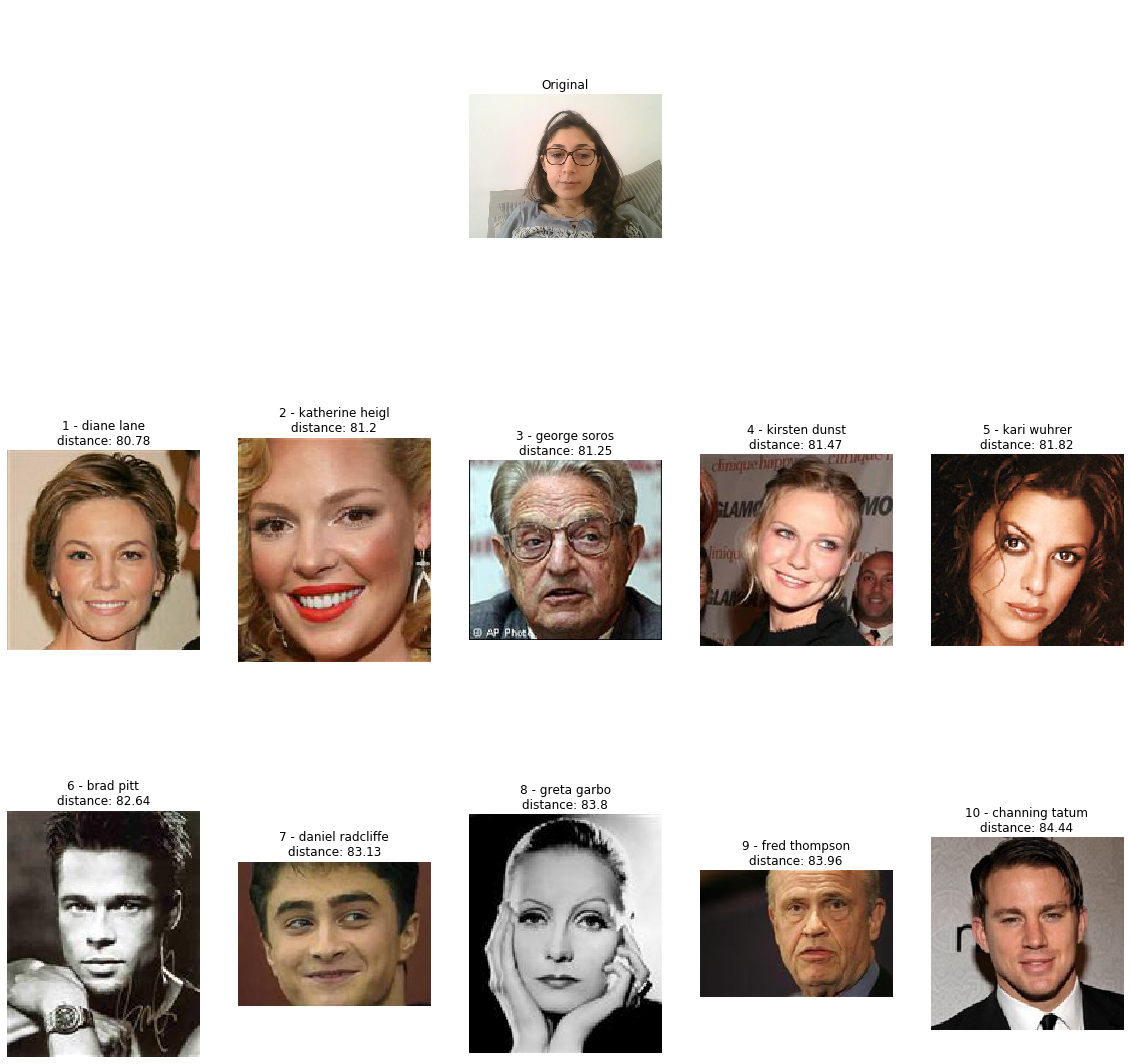

In [78]:
find_similar()